In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(7, 5))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [22]:
scaling = build_dataframe(x_axis='mpi', factor=200)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
0   200     8     1600     50         1        1        7560.0   
5   400     8     3200    100         1        1        4320.0   
7   560     8     4480    140         1        1        3339.0   
4   800     8     6400    200         1        1        2612.0   
6   960     8     7680    240         1        1        2293.0   
1  1200     8     9600    300         1        1        2117.0   
2  1360     8    10880    340         1        1        1989.0   
3  1440     8    11520    360         1        1        1882.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse   Dipoles  \
0            0.0003        0.0001  0.0005  ...           417.5454  463.9675   
5            0.0003        0.0002  0.0006  ...           212.8292  260.1591   
7            0.0003        0.0002  0.0006  ...           156.4183  211.9020   
4            0.0003        0.0002  0.0007  ...           113.6835  165.5018   
6            0.0003        0.0002  0.0005  ...            95.7495  154.7157   
1            0.0003        0.0003  0.0007  ...            80.7181  141.5695   
2            0.0003        0.0003  0.0007  ...            71.6190  137.8563   
3            0.0003        0.0002  0.0007  ...            67.8174  138.8086   

       Xo   gpu  ideal   speedup  efficiency  Self energy     Other  \
0  6720.0   200    1.0  1.000000  100.000000      19.2994  338.2073   
5  3660.0   400    2.0  1.750000   87.500000      15.3393  365.5309   
7  2775.0   560    2.8  2.264151   80.862534      11.9092  320.8021   
4  2078.0   800    4.0  2.894334   72.358346       8.7119  328.1522   
6  1831.0   960    4.8  3.296991   68.687309       9.3815  278.1238   
1  1614.0  1200    6.0  3.571091   59.518186      12.7503  328.6384   
2  1466.0  1360    6.8  3.800905   55.895661       9.3230  356.3386   
3  1374.0  1440    7.2  4.017003   55.791711       8.3182  340.8603   

       node_h  
0  105.000000  
5  120.000000  
7  129.850000  
4  145.111111  
6  152.866667  
1  176.416667  
2  187.850000  
3  188.200000  

[8 rows x 52 columns]

In [23]:
#colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
colors=['#F28F38', '#2EA6A6', '#D90718', '#47AB6C', '#112F41']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles      Xo        X  Self energy     Other
0   200        7560.0  463.9675  6720.0  18.5258      19.2994  338.2073
5   400        4320.0  260.1591  3660.0  18.9707      15.3393  365.5309
7   560        3339.0  211.9020  2775.0  19.3867      11.9092  320.8021
4   800        2612.0  165.5018  2078.0  31.6341       8.7119  328.1522
6   960        2293.0  154.7157  1831.0  19.7790       9.3815  278.1238
1  1200        2117.0  141.5695  1614.0  20.0418      12.7503  328.6384
2  1360        1989.0  137.8563  1466.0  19.4821       9.3230  356.3386
3  1440        1882.0  138.8086  1374.0  20.0129       8.3182  340.8603

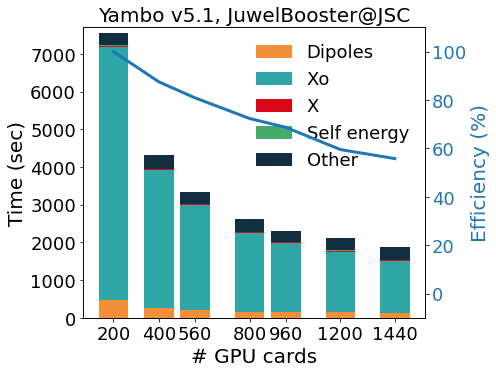

In [49]:
myscaling=scaling[(scaling.mpi!=1360)]
build_scaling_plot(scaling=myscaling, x_axis='mpi', x_label='# GPU cards',
                   pile=pile, colors=colors, bar_width=130, efficiency=True,
                   legend_loc='upper right', title=r'Yambo v5.1, JuwelBooster@JSC', 
                   file_name='yambo_scaling_gpu.png', y_lim=[0,7700])

In [46]:
def build_speedup_plot(scaling, label='yambo', title=None, y_lim=None, x_axis='mpi', file_name='speedup.png'):
    mylinestyle = {'marker':'o', 
                   'linewidth':3, 
                   'markersize':10, 
                   'markeredgewidth':3, 
                   'markerfacecolor':'white'}
    fig, ax = plt.subplots(figsize=(10, 7))
    if x_axis=='mpi':
        xlabel = 'MPI tasks'
    elif x_axis=='nodes':
        xlabel = 'Nodes'
    else:
        xlabel = x_axis
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel('Speedup',fontsize=20)
    ax.plot(scaling[x_axis], scaling['ideal'], color='gray', label='ideal', linestyle='dashed')
    ax.plot(scaling[x_axis], scaling['speedup'], 
             color='#2EA6A6', marker='.', markersize=15,
             label=label)
    if y_lim: ax.set_ylim(y_lim)
    ax.legend()
    ax.legend(fontsize='18',framealpha=0.0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.xticks(scaling[x_axis])
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

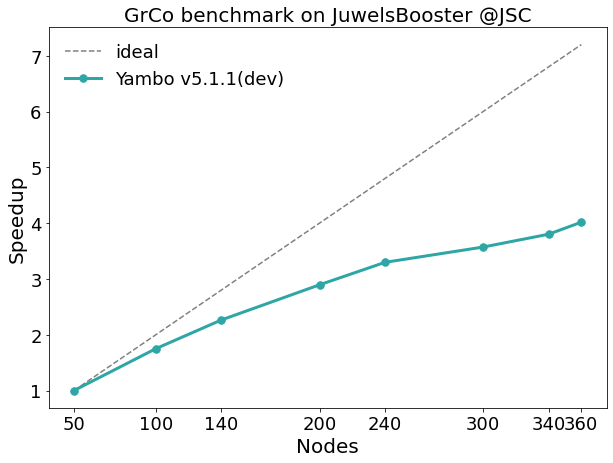

In [47]:
build_speedup_plot(scaling=scaling, title=r'GrCo benchmark on JuwelsBooster @JSC', label=r'Yambo v5.1.1(dev)', x_axis='nodes')